<a href="https://colab.research.google.com/github/peterbmob/CH-PFC/blob/main/spectral_solve_fen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# %%
# ch_spectral_fen.py
# -------------------------------------------------------------
# A spectral Cahn–Hilliard (CH) solver that mirrors the
# conventions and non-dimensionalization used in the provided
# FEniCS implementation (input 3.py + config 3.py).
#
# Key points matched to FEniCS (see input 3.py):
#   - Same non-dimensional scales: H = sigma/Wc, tc = Wc^2/D,
#     RTv = (R*T/vm)/H, Om = (Omega/vm)/H, Dm = 1/RTv.
#   - Free energy density: 1/2 |∇c|^2 + f_chem(c) + f_el(c),
#     with f_chem from regular-solution (ideal + Om*c(1-c)).
#   - Elasticity: isotropic (E, nu), using Lamé parameters
#     scaled by H, and the same eigenstrain convention as the
#     FE script: epsilon_tot = epsilon - c * epsilon0.
#   - Elastic chemical potential contribution: mu_el = -sigma:epsilon0.
#     (Sign chosen to match d/dc of elastic energy when
#      epsilon_tot = epsilon - c*epsilon0.)
#   - Optional smoothed-boundary reaction term to emulate
#     surface Butler–Volmer (dimensionless, like FEniCS),
#     disabled by default.
#
# Notes:
#   * This spectral solver is periodic in x and y, so the
#     k=0 (uniform) eigenstrain produces no elastic energy,
#     unlike the clamped boundary conditions used in the
#     FEniCS file which may store energy for uniform c.
#     For microstructural variations (nonuniform c), the
#     elastic contributions match the same scaling.
#   * Regarding C66 (spectral) vs C44 (FEniCS): in 2D Voigt
#     notation [xx, yy, xy], the shear component is labeled
#     "66"; in 3D Voigt [xx, yy, zz, yz, xz, xy], the
#     equivalent shear term is labeled "44" (and equals the
#     shear modulus mu). See explanation in the README at the
#     bottom of this file.
# -------------------------------------------------------------

from __future__ import annotations
import numpy as np
from numpy.fft import fftn, ifftn, fftfreq
import importlib
import sys
import os

# ---------- Utilities to load the provided config ----------

def _try_import_config():
    """Import config module from either 'config' or 'config 3'."""
    try:
        return importlib.import_module('config')
    except Exception:
        # Fallback: attempt to import 'config 3.py' as a module name 'config_3'
        cfg_path = os.path.join(os.getcwd(), 'config 3.py')
        if os.path.exists(cfg_path):
            spec = importlib.util.spec_from_file_location('config_3', cfg_path)
            mod = importlib.util.module_from_spec(spec)
            sys.modules['config_3'] = mod
            assert spec.loader is not None
            spec.loader.exec_module(mod)
            return mod
        raise

_config = _try_import_config()

# Extract dictionaries (names mirror the FEniCS input script)
Adapt   = getattr(_config, 'Adapt')
Domain  = getattr(_config, 'Domain')
Interval= getattr(_config, 'Interval')
Model   = getattr(_config, 'Model')

# ---------- Non-dimensionalization (match FEniCS) ----------
Wc    = float(Model["Wc"])               # [m]
sigma = float(Model["sigma"])            # [J/m^2]
DLi   = float(Model["DLi"])              # [m^2/s]
R     = float(Model["R"])                # [J/mol/K]
To    = float(Model["To"])               # [K]
vm    = float(Model["vm"])               # [m^3/mol]
Omega = float(Model["Omega"])            # [J/mol]
E     = float(Model["E"])                # [Pa]
# Model may contain Greek nu key; be robust to either 'nu' or 'ν'
nu    = Model.get('nu', Model.get('ν'))
if nu is None:
    raise KeyError("Poisson ratio 'nu'/'ν' not found in Model")
nu    = float(nu)

# Eigenstrains (2D)
e11 = float(Model.get('e11', 0.0))
e22 = float(Model.get('e22', 0.0))

# FEniCS scales
H  = sigma / Wc                # energy density scale [J/m^3]
tc = Wc**2 / DLi               # time scale [s]
RTv = (R * To / vm) / H        # dimensionless
Om  = (Omega / vm) / H         # dimensionless
Dm  = 1.0 / RTv                # dimensionless mobility pre-factor

# Time step (dimensionless, from FEniCS Interval)
dt0 = float(Interval["timestep"])  # already dimensionless in FE code

# ---------- Domain/grid setup (dimensionless lengths) ----------
# In the FEniCS file Lx, Ly are given in units of Wc. We use the
# same here and build a periodic spectral grid of size Lx x Ly.
Lx = float(Domain["Lx"])  # [Wc]
Ly = float(Domain["Ly"])  # [Wc]
# Choose grid resolution to mirror Domain['nde'] (min element size)
# and build a uniform spectral grid.
nde = float(Domain["nde"])  # [Wc]
Nx = max(8, int(np.round(Lx / nde)))
Ny = max(8, int(np.round(Ly / nde)))
# Ensure even sizes (FFT-friendly for some libraries)
if Nx % 2: Nx += 1
if Ny % 2: Ny += 1

x = np.linspace(0.0, Lx, Nx, endpoint=False)
y = np.linspace(0.0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')

# Wavenumbers in dimensionless coordinates (k with respect to x/Wc)
kx = 2*np.pi*fftfreq(Nx, d=Lx/Nx)
ky = 2*np.pi*fftfreq(Ny, d=Ly/Ny)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2
K2[0,0] = 1e-30  # avoid 0

# ---------- Elasticity (dimensionless stiffness) ----------
# Lamé parameters in physical units
lam = E*nu/((1+nu)*(1-2*nu))    # [Pa]
mu  = E/(2*(1+nu))              # [Pa]
# Dimensionless (divide by H)
lam_d = lam / H
mu_d  = mu  / H

# Build 4th-rank isotropic stiffness in 2D (plane strain) with components:
#   C_ijkl = lam_d * delta_ij * delta_kl + mu_d * (delta_ik * delta_jl + delta_il * delta_jk)
# We store as a (2,2,2,2) ndarray.

def _delta(i,j):
    return 1.0 if i==j else 0.0

C = np.zeros((2,2,2,2), dtype=float)
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                C[i,j,k,l] = (
                    lam_d * _delta(i,j) * _delta(k,l) +
                    mu_d  * (_delta(i,k)*_delta(j,l) + _delta(i,l)*_delta(j,k))
                )

# Eigenstrain tensor (constant in space, multiplied by local c)
Eps0 = np.zeros((2,2), dtype=float)
Eps0[0,0] = e11
Eps0[1,1] = e22
# (off-diagonals 0 by default)

# Precompute A(k) = k_j C_ijkl k_k and its inverse for all k
K = np.stack((KX, KY), axis=-1)  # (...,2)
A = np.einsum('...j,ijkl,...k->...il', K, C, K)  # (Nx,Ny,2,2)
A11 = A[...,0,0]; A12 = A[...,0,1]; A21 = A[...,1,0]; A22 = A[...,1,1]
detA = A11*A22 - A12*A21
mask_k0 = (np.abs(KX)<1e-14) & (np.abs(KY)<1e-14)
detA[mask_k0] = 1.0
invA = np.empty_like(A)
invA[...,0,0] = A22/detA
invA[...,0,1] = -A12/detA
invA[...,1,0] = -A21/detA
invA[...,1,1] = A11/detA

# ---------- Free energy: chemical (dimensionless) ----------
# f_chem(c) = RTv*( c ln c + (1-c) ln(1-c) ) + Om*c(1-c)
# mu_chem(c) = d f_chem / dc  - (∇^2 c)  [since fgrad = 1/2 |∇c|^2]

eps_clip = 1e-12

def f_chem(c: np.ndarray) -> np.ndarray:
    ce = np.clip(c, eps_clip, 1.0-eps_clip)
    ideal = RTv * (ce*np.log(ce) + (1-ce)*np.log(1-ce))
    rs    = Om * ce*(1.0-ce)
    return ideal + rs

def dfdc_chem(c: np.ndarray) -> np.ndarray:
    ce = np.clip(c, eps_clip, 1.0-eps_clip)
    return RTv * (np.log(ce) - np.log(1.0-ce)) + Om*(1.0 - 2.0*ce)

# ---------- Spectral differential operators ----------

def laplace(f: np.ndarray) -> np.ndarray:
    return np.real(ifftn(-K2 * fftn(f)))

# ---------- Spectral microelasticity ----------
# Solve for displacement u in Fourier space for given eigenstrain field c(x)*Eps0
# with periodic BCs. Then compute sigma, elastic energy density, and mu_el = -sigma:Eps0

def solve_elastic(c: np.ndarray):
    # Eigenstrain tensor field E0(x)
    E0 = np.zeros((Nx,Ny,2,2), dtype=float)
    E0[...,0,0] = c * Eps0[0,0]
    E0[...,1,1] = c * Eps0[1,1]
    # FFT of E0
    E0k = np.zeros_like(E0, dtype=complex)
    for a in range(2):
        for b in range(2):
            E0k[...,a,b] = fftn(E0[...,a,b])
    # RHS b_i = i k_j C_ijkl E0_kl
    b = 1j * np.einsum('...j,ijkl,...kl->...i', K, C, E0k)
    # Solve u_k = invA * b; set k=0 mode to 0
    u_k = np.einsum('...ij,...j->...i', invA, b)
    u_k[mask_k0,...] = 0.0
    # Strain in Fourier: eps_kl = 0.5i (k_k u_l + k_l u_k)
    Ux = u_k[...,0]; Uy = u_k[...,1]
    Exx_k = 1j*KX*Ux
    Eyy_k = 1j*KY*Uy
    Exy_k = 0.5j*(KX*Uy + KY*Ux)
    Exx = np.real(ifftn(Exx_k))
    Eyy = np.real(ifftn(Eyy_k))
    Exy = np.real(ifftn(Exy_k))
    # dE = eps - E0
    dE = np.zeros_like(E0)
    dE[...,0,0] = Exx - E0[...,0,0]
    dE[...,0,1] = Exy - E0[...,0,1]
    dE[...,1,0] = Exy - E0[...,1,0]
    dE[...,1,1] = Eyy - E0[...,1,1]
    # Stress sigma = C : dE
    sigma = np.einsum('ijkl,...kl->...ij', C, dE)
    # Elastic energy density
    f_el = 0.5 * np.einsum('...ij,ijkl,...kl->...', dE, C, dE)
    # Elastic chemical potential (sign carefully chosen): mu_el = - sigma : (∂E0/∂c) = - sigma : Eps0
    mu_el = - ( sigma[...,0,0]*Eps0[0,0] + sigma[...,1,1]*Eps0[1,1] + 2.0*sigma[...,0,1]*Eps0[0,1] )
    # Diagnostics
    strain_mag = np.sqrt(Exx**2 + Eyy**2 + 2.0*Exy**2)
    von_mises = np.sqrt((sigma[...,0,0]-sigma[...,1,1])**2 + 3.0*(2.0*sigma[...,0,1])**2)
    return mu_el, f_el, (Exx,Eyy,Exy), (sigma[...,0,0], sigma[...,1,1], sigma[...,0,1]), strain_mag, von_mises

# ---------- CH time step (semi-implicit on bi-Laplacian) ----------
# ∂c/∂t = ∇·( Dm c(1-c) ∇μ ),  μ = dfdc_chem(c) - ∇²c + mu_el
# Use constant Mlin = Dm*0.25 in the stiff part to stabilize.
Mlin = Dm * 0.25
Ak = 1.0 + dt0 * Mlin * (K2**2)


def divergence_of_M_grad_mu(Mc: np.ndarray, mu: np.ndarray) -> np.ndarray:
    muk = fftn(mu)
    mux = np.real(ifftn(1j*KX*muk))
    muy = np.real(ifftn(1j*KY*muk))
    jx = Mc * mux
    jy = Mc * muy
    jkx = fftn(jx)
    jky = fftn(jy)
    return np.real(ifftn(1j*KX*jkx + 1j*KY*jky))


def step_CH(c: np.ndarray, dt: float) -> tuple[np.ndarray, dict]:
    mu_el, f_el, strains, stresses, strain_mag, vm = solve_elastic(c)
    mu_chem = dfdc_chem(c) - laplace(c)
    mu = mu_chem + mu_el
    Mc = Dm * c*(1.0 - c)
    div_term = divergence_of_M_grad_mu(Mc, mu)
    rhs = c + dt * div_term
    c_new = np.real(ifftn(fftn(rhs) / Ak))
    c_new = np.clip(c_new, 1e-8, 1.0-1e-8)
    info = {
        'mu': mu, 'mu_el': mu_el, 'f_el': f_el,
        'strains': strains, 'stresses': stresses,
        'strain_mag': strain_mag, 'von_mises': vm
    }
    return c_new, info



In [6]:
def run_demo(nsteps: int = 200, seed: int = 0, report_every: int = 50):
    rng = np.random.default_rng(seed)
    # Initial condition similar to FE: choose lithiation/delithation by mean c
    c = 0.50 + 0.02 * (rng.random((Nx,Ny)) - 0.5)
    c = np.clip(c, 1e-3, 1.0-1e-3)

    dt = dt0  # use FE's dimensionless timestep

    print("--- ch_spectral_fen.py ---")
    print(f"Grid: {Nx} x {Ny}, domain Lx={Lx} Ly={Ly} [in units of Wc]")
    print(f"Scales: H={H:.3e} J/m^3, tc={tc:.3e} s, RTv={RTv:.3e}, Om={Om:.3e}, Dm={Dm:.3e}")
    print(f"Elastic (dimless): lam/H={lam_d:.3e}, mu/H={mu_d:.3e}; eps0=[{e11:.4g},{e22:.4g}]")
    print(f"dt (dimless) = {dt:.3e}; runtime target (dimless) ~ {Interval['runtime']:.3e}")

    for it in range(1, nsteps+1):
        c, info = step_CH(c, dt)
        if it % report_every == 0:
            fchem = f_chem(c).mean()
            fel   = info['f_el'].mean()
            print(f"step {it:5d} | <f_chem>={fchem: .3e}, <f_el>={fel: .3e}, <c>={c.mean():.4f}")
    return c, info

In [7]:
if __name__ == '__main__':
    # Quick run to verify the script works end-to-end
    c_final, info_final = run_demo(nsteps=50, report_every=25)
    # Save a small checkpoint (NumPy NPZ)
    np.savez('ch_spectral_fen_checkpoint.npz',
             c=c_final, f_el_mean=float(info_final['f_el'].mean()),
             Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly,
             RTv=RTv, Om=Om, Dm=Dm, lam_d=lam_d, mu_d=mu_d)
    print("Saved: ch_spectral_fen_checkpoint.npz")

--- ch_spectral_fen.py ---
Grid: 256 x 128, domain Lx=64.0 Ly=32.0 [in units of Wc]
Scales: H=7.200e+07 J/m^3, tc=1.000e-03 s, RTv=7.857e-01, Om=3.805e+00, Dm=1.273e+00
Elastic (dimless): lam/H=7.085e+02, mu/H=6.972e+02; eps0=[0.0165,0.0036]
dt (dimless) = 1.000e-03; runtime target (dimless) ~ 1.000e-03
step    25 | <f_chem>= 4.067e-01, <f_el>= 8.550e-02, <c>=0.5000
step    50 | <f_chem>= 4.067e-01, <f_el>= 8.550e-02, <c>=0.5000
Saved: ch_spectral_fen_checkpoint.npz


=== Analysis of checkpoint ===
<c> = 0.893381, std(c) = 0.283829
<f_chem> = 1.697943e-02
<f_grad> = 8.056206e-03
<f_el>   = 3.589337e-01
<F_total>= 3.839693e-01
Saved: analysis_fields.png


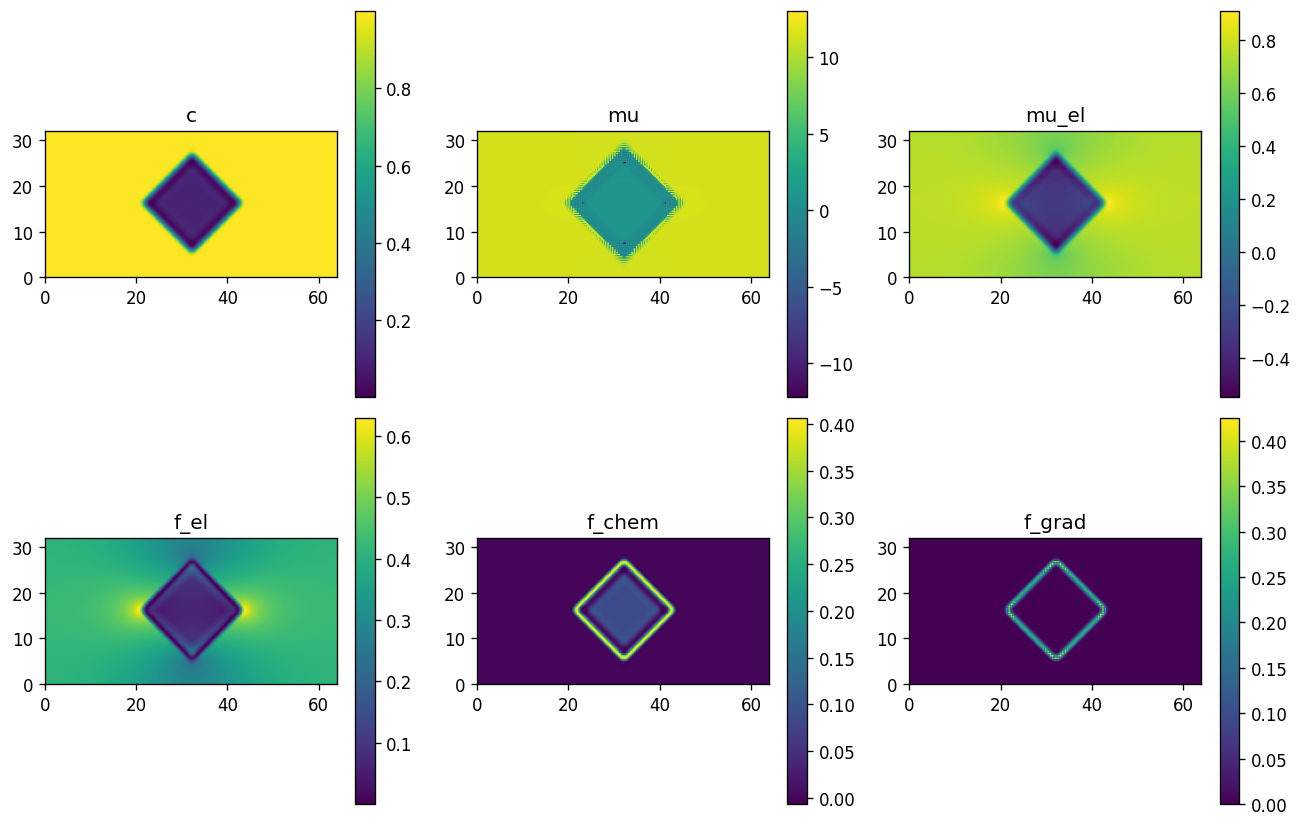

In [22]:
#!/usr/bin/env python3
"""
Analyze a spectral CH checkpoint saved by ch_spectral_fen.py
and produce diagnostic plots for fields and energies.

Usage:
  python analyze_checkpoint.py [checkpoint.npz]

If no file is given, defaults to 'ch_spectral_fen_checkpoint.npz'.
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, ifftn, fftfreq
import sys, os, importlib
import importlib.util # Moved this import to the top

# --- Load checkpoint ---
# Adjusting to handle potential extra arguments in notebook environments
fn = 'ch_spectral_fen_checkpoint.npz'
# Filter out potential non-filename arguments, being more specific about expected file extensions
potential_fns = [arg for arg in sys.argv[1:] if arg.endswith('.npz')]
if potential_fns:
    fn = potential_fns[0]

data = np.load(fn, allow_pickle=True)

c  = data['c']               # (Nx,Ny)
Nx = int(data['Nx']); Ny = int(data['Ny'])
Lx = float(data['Lx']); Ly = float(data['Ly'])
RTv = float(data['RTv']); Om = float(data['Om'])
Dm  = float(data['Dm'])
lam_d = float(data['lam_d']); mu_d = float(data['mu_d'])

# --- Import config to get eigenstrains (e11,e22) ---
# Accept either config.py or 'config 3.py' as module.

def _try_import_config():
    try:
        return importlib.import_module('config')
    except Exception:
        cfg_path = os.path.join(os.getcwd(), 'config 3.py')
        if os.path.exists(cfg_path):
            spec = importlib.util.spec_from_file_location('config_3', cfg_path)
            mod = importlib.util.module_from_spec(spec)
            sys.modules['config_3'] = mod
            assert spec.loader is not None
            spec.loader.exec_module(mod)
            return mod
        raise

_config = _try_import_config()
Model = getattr(_config, 'Model')
e11 = float(Model.get('e11', 0.0))
e22 = float(Model.get('e22', 0.0))

# --- Grid and wavenumbers ---
x = np.linspace(0.0, Lx, Nx, endpoint=False)
y = np.linspace(0.0, Ly, Ny, endpoint=False)
KX = 2*np.pi*fftfreq(Nx, d=Lx/Nx)
KY = 2*np.pi*fftfreq(Ny, d=Ly/Ny)
KX, KY = np.meshgrid(KX, KY, indexing='ij')
K2 = KX**2 + KY**2
K2[0,0] = 1e-30

# --- Free-energy pieces (dimensionless) ---
eps = 1e-12

def f_chem(c):
    ce = np.clip(c, eps, 1.0-eps)
    return RTv * (ce*np.log(ce) + (1-ce)*np.log(1-ce)) + Om * ce*(1.0-ce)

def dfdc_chem(c):
    ce = np.clip(c, eps, 1.0-eps)
    return RTv*(np.log(ce) - np.log(1.0-ce)) + Om*(1.0-2.0*ce)

def laplace(f):
    return np.real(ifftn(-K2*fftn(f)))

# --- Elasticity ---
# Build 4th-rank isotropic stiffness (dimensionless)
C = np.zeros((2,2,2,2))
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                C[i,j,k,l] = lam_d*(1.0 if i==j else 0.0)*(1.0 if k==l else 0.0) \
                             + mu_d*((1.0 if i==k else 0.0)*(1.0 if j==l else 0.0) \
                                    + (1.0 if i==l else 0.0)*(1.0 if j==k else 0.0))
Eps0 = np.zeros((2,2)); Eps0[0,0]=e11; Eps0[1,1]=e22

K = np.stack((KX, KY), axis=-1)
A = np.einsum('...j,ijkl,...k->...il', K, C, K)
A11=A[...,0,0]; A12=A[...,0,1]; A21=A[...,1,0]; A22=A[...,1,1]
detA = A11*A22 - A12*A21
mask0 = (np.abs(KX)<1e-14) & (np.abs(KY)<1e-14)
detA[mask0]=1.0
invA = np.empty_like(A)
invA[...,0,0]=A22/detA; invA[...,0,1]=-A12/detA
invA[...,1,0]=-A21/detA; invA[...,1,1]=A11/detA

# Solve elasticity for given c
E0 = np.zeros((Nx,Ny,2,2))
E0[...,0,0]=c*Eps0[0,0]
E0[...,1,1]=c*Eps0[1,1]
E0k = np.zeros_like(E0, dtype=complex)
for a in range(2):
    for b in range(2):
        E0k[...,a,b] = fftn(E0[...,a,b])

b = 1j*np.einsum('...j,ijkl,...kl->...i', K, C, E0k)
u_k = np.einsum('...ij,...j->...i', invA, b)
u_k[mask0,...]=0.0
Ux = u_k[...,0]; Uy=u_k[...,1]
Exx_k = 1j*KX*Ux; Eyy_k = 1j*KY*Uy; Exy_k = 0.5j*(KX*Uy + KY*Ux)
Exx = np.real(ifftn(Exx_k)); Eyy=np.real(ifftn(Eyy_k)); Exy=np.real(ifftn(Exy_k))
# dE = eps - E0
E0xx=E0[...,0,0]; E0yy=E0[...,1,1]
dExx = Exx - E0xx; dEyy = Eyy - E0yy; dExy = Exy
# Stress sigma = C : dE
sigma = np.zeros((Nx,Ny,2,2))
# Build dE tensor field to contract
DE = np.zeros_like(E0)
DE[...,0,0]=dExx; DE[...,1,1]=dEyy; DE[...,0,1]=dExy; DE[...,1,0]=dExy
sigma = np.einsum('ijkl,...kl->...ij', C, DE)

# Energies and potentials
f_el = 0.5*np.einsum('...ij,ijkl,...kl->...', DE, C, DE)
mu_el = -(sigma[...,0,0]*Eps0[0,0] + sigma[...,1,1]*Eps0[1,1] + 2.0*sigma[...,0,1]*Eps0[0,1])
mu = dfdc_chem(c) - laplace(c) + mu_el

# Gradient energy density 1/2 |∇c|^2
ck = fftn(c)
dcx = np.real(ifftn(1j*KX*ck)); dcy = np.real(ifftn(1j*KY*ck))
f_grad = 0.5*(dcx**2 + dcy**2)

# --- Print & plot ---
print("=== Analysis of checkpoint ===")
print(f"<c> = {c.mean():.6f}, std(c) = {c.std():.6f}")
print(f"<f_chem> = {f_chem(c).mean():.6e}")
print(f"<f_grad> = {f_grad.mean():.6e}")
print(f"<f_el>   = {f_el.mean():.6e}")
print(f"<F_total>= {(f_chem(c)+f_grad+f_el).mean():.6e}")

extent=[0,Lx,0,Ly]
fig,axs=plt.subplots(2,3,figsize=(11,7))
im=axs[0,0].imshow(c.T,origin='lower',extent=extent); axs[0,0].set_title('c')
plt.colorbar(im,ax=axs[0,0])
im=axs[0,1].imshow(mu.T,origin='lower',extent=extent); axs[0,1].set_title('mu')
plt.colorbar(im,ax=axs[0,1])
im=axs[0,2].imshow(mu_el.T,origin='lower',extent=extent); axs[0,2].set_title('mu_el')
plt.colorbar(im,ax=axs[0,2])
im=axs[1,0].imshow(f_el.T,origin='lower',extent=extent); axs[1,0].set_title('f_el')
plt.colorbar(im,ax=axs[1,0])
im=axs[1,1].imshow(f_chem(c).T,origin='lower',extent=extent); axs[1,1].set_title('f_chem')
plt.colorbar(im,ax=axs[1,1])
im=axs[1,2].imshow(f_grad.T,origin='lower',extent=extent); axs[1,2].set_title('f_grad')
plt.colorbar(im,ax=axs[1,2])
plt.tight_layout()
plt.savefig('analysis_fields.png',dpi=150)
print('Saved: analysis_fields.png')

Saved: uniform_sweep_energy.png


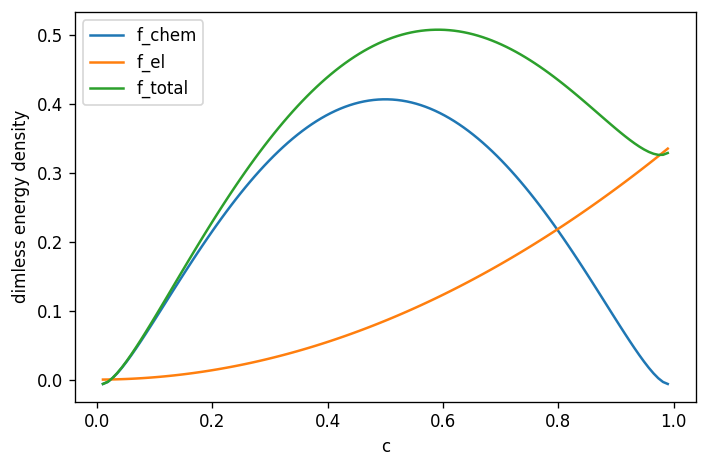

In [23]:
#!/usr/bin/env python3
"""
Sweep uniform concentration c and compute chemical & elastic energy
under the same normalization as ch_spectral_fen.py (periodic BCs).

Usage:
  python analyze_sweep_uniform.py [Nx Ny Lx Ly]
Defaults: read from checkpoint if present; otherwise (256,128,64,32).
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, ifftn, fftfreq
import os, importlib, sys
import importlib.util # Moved this import to the top

# Try to read checkpoint for grid/scales
Nx=256; Ny=128; Lx=64.0; Ly=32.0
RTv=0.7857; Om=3.805; lam_d=708.5; mu_d=697.2
try:
    data=np.load('ch_spectral_fen_checkpoint.npz', allow_pickle=True)
    Nx=int(data['Nx']); Ny=int(data['Ny']); Lx=float(data['Lx']); Ly=float(data['Ly'])
    RTv=float(data['RTv']); Om=float(data['Om'])
    lam_d=float(data['lam_d']); mu_d=float(data['mu_d'])
except Exception:
    pass

# Allow cmdline overrides
if len(sys.argv)>=5:
    Nx=int(sys.argv[1]); Ny=int(sys.argv[2]); Lx=float(sys.argv[3]); Ly=float(sys.argv[4])

# Import config for eigenstrain

def _try_import_config():
    try:
        return importlib.import_module('config')
    except Exception:
        cfg_path = os.path.join(os.getcwd(), 'config 3.py')
        if os.path.exists(cfg_path):
            spec = importlib.util.spec_from_file_location('config_3', cfg_path)
            mod = importlib.util.module_from_spec(spec)
            sys.modules['config_3'] = mod
            assert spec.loader is not None
            spec.loader.exec_module(mod)
            return mod
        raise

_config=_try_import_config()
Model=getattr(_config,'Model')
e11=float(Model.get('e11',0.0)); e22=float(Model.get('e22',0.0))

# Grid and operators
KX = 2*np.pi*fftfreq(Nx, d=Lx/Nx); KY=2*np.pi*fftfreq(Ny, d=Ly/Ny)
KX,KY=np.meshgrid(KX,KY,indexing='ij')
K2=KX**2+KY**2; K2[0,0]=1e-30

# Stiffness tensor
C=np.zeros((2,2,2,2))
for i in range(2):
  for j in range(2):
    for k in range(2):
      for l in range(2):
        C[i,j,k,l]=lam_d*(1 if i==j else 0)*(1 if k==l else 0) + mu_d*((1 if i==k else 0)*(1 if j==l else 0)+(1 if i==l else 0)*(1 if j==k else 0))
Eps0=np.zeros((2,2)); Eps0[0,0]=e11; Eps0[1,1]=e22

K=np.stack((KX,KY),axis=-1)
A=np.einsum('...j,ijkl,...k->...il',K,C,K)
A11=A[...,0,0];A12=A[...,0,1];A21=A[...,1,0];A22=A[...,1,1]
detA=A11*A22-A12*A21
mask0=(np.abs(KX)<1e-14)&(np.abs(KY)<1e-14)
detA[mask0]=1.0
invA=np.empty_like(A)
invA[...,0,0]=A22/detA; invA[...,0,1]=-A12/detA
invA[...,1,0]=-A21/detA; invA[...,1,1]=A11/detA

# helpers

def f_chem(c):
    ce=np.clip(c,1e-12,1-1e-12)
    return RTv*(ce*np.log(ce)+(1-ce)*np.log(1-ce))+Om*ce*(1-ce)

# sweep
cs=np.linspace(0.01,0.99,120)
fel=[]; fchem=[]; ftotal=[]
for ci in cs:
    c=ci*np.ones((Nx,Ny))
    # eigenstrain
    E0=np.zeros((Nx,Ny,2,2)); E0[...,0,0]=c*Eps0[0,0]; E0[...,1,1]=c*Eps0[1,1]
    E0k=np.zeros_like(E0,dtype=complex)
    for a in range(2):
        for b in range(2):
            E0k[...,a,b]=fftn(E0[...,a,b])
    b=1j*np.einsum('...j,ijkl,...kl->...i',K,C,E0k)
    u_k=np.einsum('...ij,...j->...i',invA,b)
    u_k[mask0,...]=0.0
    Ux=u_k[...,0]; Uy=u_k[...,1]
    Exx=np.real(ifftn(1j*KX*Ux))
    Eyy=np.real(ifftn(1j*KY*Uy))
    Exy=np.real(ifftn(0.5j*(KX*Uy+KY*Ux)))
    DE=np.zeros_like(E0)
    DE[...,0,0]=Exx-E0[...,0,0]
    DE[...,1,1]=Eyy-E0[...,1,1]
    DE[...,0,1]=Exy; DE[...,1,0]=Exy
    f_el=0.5*np.einsum('...ij,ijkl,...kl->...',DE,C,DE).mean()
    fel.append(f_el)
    fc=f_chem(ci).mean() # uniform => scalar
    fchem.append(fc)
    ftotal.append(fc+f_el)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(cs,np.array(fchem),label='f_chem')
plt.plot(cs,np.array(fel),label='f_el')
plt.plot(cs,np.array(ftotal),label='f_total')
plt.xlabel('c'); plt.ylabel('dimless energy density')
plt.legend(); plt.tight_layout()
plt.savefig('uniform_sweep_energy.png',dpi=150)
print('Saved: uniform_sweep_energy.png')

Peak k* = 0.0444 (=> length ~ 141.4214 in Wc units)
Saved: structure_factor.png, structure_factor.csv


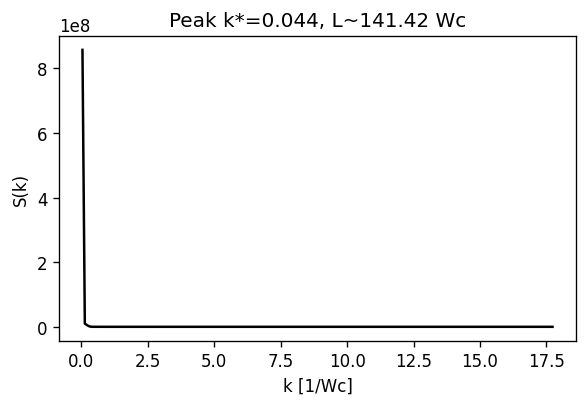

In [24]:
#!/usr/bin/env python3
"""
Compute and plot the isotropically averaged structure factor S(k)
from a checkpoint (or any 2D c-field stored in NPZ).

Usage:
  python analyze_structure_factor.py [checkpoint.npz]
Saves: structure_factor.png and structure_factor.csv
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, fftshift, fftfreq
import sys

potential_fns = [arg for arg in sys.argv[1:] if arg.endswith('.npz')]
if potential_fns:
    fn = potential_fns[0]

data = np.load(fn, allow_pickle=True)
c=data['c']
Nx=int(data['Nx']); Ny=int(data['Ny'])
Lx=float(data['Lx']); Ly=float(data['Ly'])

ck=fftn(c)
Sk=np.abs(ck)**2
# frequencies (physical k)
kx=2*np.pi*fftfreq(Nx, d=Lx/Nx)
ky=2*np.pi*fftfreq(Ny, d=Ly/Ny)
KX,KY=np.meshgrid(kx,ky,indexing='ij')
K=np.sqrt(KX**2+KY**2)

# radial binning
kmax=float(np.max(K))
nbin=200
bins=np.linspace(0,kmax,nbin+1)
centers=0.5*(bins[:-1]+bins[1:])
Srad=np.zeros(nbin); counts=np.zeros(nbin)
inds=np.digitize(K.ravel(), bins)-1
for i in range(nbin):
    mask=(inds==i)
    if np.any(mask):
        Srad[i]=Sk.ravel()[mask].mean()
        counts[i]=mask.sum()

# characteristic length from peak
ipeak=np.argmax(Srad)
kstar=centers[ipeak]
length=2*np.pi/max(kstar,1e-12)
print(f"Peak k* = {kstar:.4f} (=> length ~ {length:.4f} in Wc units)")

# save csv
import pandas as pd
pd.DataFrame({'k':centers,'S(k)':Srad,'counts':counts}).to_csv('structure_factor.csv',index=False)

plt.figure(figsize=(5,3.5))
plt.plot(centers,Srad,'k-')
plt.xlabel('k [1/Wc]'); plt.ylabel('S(k)')
plt.title(f'Peak k*={kstar:.3f}, L~{length:.2f} Wc')
plt.tight_layout(); plt.savefig('structure_factor.png',dpi=150)
print('Saved: structure_factor.png, structure_factor.csv')

In [21]:
# %%
# ch_spectral_fen.py  (masked + BV kinetics)
# -------------------------------------------------------------
# Spectral CH solver aligned with the FEniCS nondimensionalization
# and elasticity from input 3.py, augmented with a smoothed-
# boundary mask H for particle-in-reservoir and a Butler–Volmer
# surface flux converted to a volumetric source via δΓ ≈ |∇H|.
# -------------------------------------------------------------
from __future__ import annotations
import numpy as np
from numpy.fft import fftn, ifftn, fftfreq
import importlib, sys, os

# ---------- Load config (accepts config.py or 'config 3.py') ----------
def _try_import_config():
    try:
        return importlib.import_module('config')
    except Exception:
        cfg_path = os.path.join(os.getcwd(), 'config 3.py')
        if os.path.exists(cfg_path):
            spec = importlib.util.spec_from_file_location('config_3', cfg_path)
            mod = importlib.util.module_from_spec(spec)
            sys.modules['config_3'] = mod
            assert spec.loader is not None
            spec.loader.exec_module(mod)
            return mod
        raise

_config = _try_import_config()
Adapt   = getattr(_config, 'Adapt')
Domain  = getattr(_config, 'Domain')
Interval= getattr(_config, 'Interval')
Model   = getattr(_config, 'Model')

# ---------- FE-aligned nondimensionalization ----------
Wc    = float(Model["Wc"])               # [m]
sigma = float(Model["sigma"])            # [J/m^2]
DLi   = float(Model["DLi"])              # [m^2/s]
R     = float(Model["R"])                # [J/mol/K]
To    = float(Model["To"])               # [K]
vm    = float(Model["vm"])               # [m^3/mol]
Omega = float(Model["Omega"])            # [J/mol]
E     = float(Model["E"])                # [Pa]
nu    = Model.get('nu', Model.get('ν'))
if nu is None:
    raise KeyError("Poisson ratio 'nu'/'ν' not found in Model")
nu    = float(nu)

# Electrochem params for BV (mirror FE)
Fconst = float(Model.get('F', 96485.33))
NA     = float(Model.get('Nₐ', Model.get('Nα', Model.get('NA', 6.02214076e23))))
DeltaPhi = float(Model.get('Δφ', Model.get('DeltaPhi', 0.0)))  # [V]
mu_eq    = float(Model.get('μeq', Model.get('mueq', 0.0)))     # [J/m^3]
alpha    = 0.5  # transfer coefficient

# j0 or k0 -> FE’s dimensionless j0coeff
j0 = Model.get('j0', None)
if j0 is None:
    k0 = float(Model.get('k0', 2.035e-4))  # [s^-1]
    j0 = (Fconst/(NA * Wc**2)) * k0        # [A/m^2]
else:
    j0 = float(j0)

Hscale = sigma / Wc                 # H = sigma/Wc  [J/m^3]
tc     = Wc**2 / DLi                # [s]
RTv    = (R * To / vm) / Hscale     # dimensionless
Om     = (Omega / vm) / Hscale      # dimensionless
Dm     = 1.0 / RTv                  # dimensionless mobility prefactor
j0coeff = (vm * j0 / Fconst) * (tc / Wc)  # dimensionless (exactly like FE)
mu_elec = (mu_eq - (Fconst * DeltaPhi)/vm) / Hscale  # dimensionless μ_elec

# ---------- Domain & grid (lengths in Wc units) ----------
Lx = float(Domain["Lx"]); Ly = float(Domain["Ly"])
nde = float(Domain["nde"])
Nx = max(8, int(round(Lx/nde))); Ny = max(8, int(round(Ly/nde)))
if Nx % 2: Nx += 1
if Ny % 2: Ny += 1
x = np.linspace(0.0, Lx, Nx, endpoint=False)
y = np.linspace(0.0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')

kx = 2*np.pi*fftfreq(Nx, d=Lx/Nx)
ky = 2*np.pi*fftfreq(Ny, d=Ly/Ny)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2
K2[0,0] = 1e-30

# ---------- Mask H(X) + smoothed boundary δΓ ----------
# shape: 'diamond' | 'hex' | 'circle'
mask_shape    = 'diamond'
r_electrode_Wc= 0.39*min(Lx,Ly)
center = (Lx/2, Ly/2)
sigma_smooth = min(Lx/Nx, Ly/Ny)  # ~1 grid cell

def make_mask(shape='diamond', r=r_electrode_Wc, center=center):
    cx, cy = center
    XX = (X - cx); YY = (Y - cy)
    if shape == 'diamond':
        raw = (np.abs(XX) + np.abs(YY)) <= r
    elif shape == 'hex':
        s3o2 = np.sqrt(3)/2
        ax, ay = np.abs(XX), np.abs(YY)
        raw = np.maximum(ay, s3o2*ax + 0.5*ay) <= r
    else:  # circle
        raw = (XX**2 + YY**2) <= r**2
    return raw.astype(float)

def gaussian_filter_field(f, sigma_len):
    G = np.exp(-0.5*((KX*sigma_len)**2 + (KY*sigma_len)**2))
    return np.real(ifftn(fftn(f)*G))

def grad_field(f):
    fk = fftn(f)
    fx = np.real(ifftn(1j*KX*fk))
    fy = np.real(ifftn(1j*KY*fk))
    return fx, fy

H_raw = make_mask(mask_shape, r_electrode_Wc, center)
H = gaussian_filter_field(H_raw, sigma_smooth)
Hx, Hy = grad_field(H)
delta_Gamma = np.sqrt(Hx**2 + Hy**2) + 1e-14

# ---------- Elasticity (dimensionless) ----------
lam = E*nu/((1+nu)*(1-2*nu)); mu  = E/(2*(1+nu))
lam_d = lam / Hscale;          mu_d  = mu  / Hscale
C = np.zeros((2,2,2,2))
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                C[i,j,k,l] = lam_d*(1 if i==j else 0)*(1 if k==l else 0) \
                             + mu_d*((1 if i==k else 0)*(1 if j==l else 0)
                                    + (1 if i==l else 0)*(1 if j==k else 0))

e11 = float(Model.get('e11', 0.0)); e22 = float(Model.get('e22', 0.0))
Eps0 = np.zeros((2,2)); Eps0[0,0]=e11; Eps0[1,1]=e22

K = np.stack((KX, KY), axis=-1)
A = np.einsum('...j,ijkl,...k->...il', K, C, K)
A11=A[...,0,0]; A12=A[...,0,1]; A21=A[...,1,0]; A22=A[...,1,1]
detA = A11*A22 - A12*A21
mask0 = (np.abs(KX)<1e-14) & (np.abs(KY)<1e-14)
detA[mask0]=1.0
invA = np.empty_like(A)
invA[...,0,0]=A22/detA; invA[...,0,1]=-A12/detA
invA[...,1,0]=-A21/detA; invA[...,1,1]=A11/detA

# ---------- Free energy (dimensionless) ----------
eps_clip = 1e-12
def f_chem(c):
    ce = np.clip(c, eps_clip, 1.0-eps_clip)
    return RTv*(ce*np.log(ce) + (1-ce)*np.log(1-ce)) + Om*ce*(1.0-ce)

def dfdc_chem(c):
    ce = np.clip(c, eps_clip, 1.0-eps_clip)
    return RTv*(np.log(ce) - np.log(1.0-ce)) + Om*(1.0 - 2.0*ce)

def laplace(f):
    return np.real(ifftn(-K2*fftn(f)))

# ---------- Elastic solver ----------
def solve_elastic(c):
    E0 = np.zeros((Nx,Ny,2,2))
    E0[...,0,0] = c*Eps0[0,0]; E0[...,1,1] = c*Eps0[1,1]
    E0k = np.zeros_like(E0, dtype=complex)
    for a in range(2):
        for b in range(2):
            E0k[...,a,b] = fftn(E0[...,a,b])
    b = 1j*np.einsum('...j,ijkl,...kl->...i', K, C, E0k)
    u_k = np.einsum('...ij,...j->...i', invA, b)
    u_k[mask0,...]=0.0
    Ux=u_k[...,0]; Uy=u_k[...,1]
    Exx = np.real(ifftn(1j*KX*Ux))
    Eyy = np.real(ifftn(1j*KY*Uy))
    Exy = np.real(ifftn(0.5j*(KX*Uy + KY*Ux)))
    DE = np.zeros_like(E0)
    DE[...,0,0]=Exx - E0[...,0,0]
    DE[...,1,1]=Eyy - E0[...,1,1]
    DE[...,0,1]=Exy; DE[...,1,0]=Exy
    sigma = np.einsum('ijkl,...kl->...ij', C, DE)
    f_el = 0.5*np.einsum('...ij,ijkl,...kl->...', DE, C, DE)
    mu_el = -(sigma[...,0,0]*Eps0[0,0] + sigma[...,1,1]*Eps0[1,1] + 2.0*sigma[...,0,1]*Eps0[0,1])
    return mu_el, f_el

# ---------- BV kinetics (dimensionless, FE-like) ----------
def J_BV(mu):
    eta = (mu_elec - mu) / RTv
    return j0coeff * (np.exp(alpha*eta) - np.exp(-(1.0-alpha)*eta))

# ---------- CH step ----------
Mlin = Dm*0.25
Ak = 1.0 + float(Interval['timestep'])*Mlin*(K2**2)

def divergence_of_M_grad_mu(Mc, mu):
    muk = fftn(mu)
    mux = np.real(ifftn(1j*KX*muk))
    muy = np.real(ifftn(1j*KY*muk))
    jx = Mc*mux
    jy = Mc*muy
    return np.real(ifftn(1j*KX*fftn(jx) + 1j*KY*fftn(jy)))

def step_CH(c, dt):
    mu_el, f_el = solve_elastic(c)
    mu = dfdc_chem(c) - laplace(c) + mu_el
    Mc = Dm * (H * c * (1.0 - c))               # diffusion only in particle
    div_term = divergence_of_M_grad_mu(Mc, mu)
    J = J_BV(mu)                                 # boundary flux (dimless)
    Rsrc = J * delta_Gamma                       # smoothed-boundary source
    rhs = c + dt*(div_term + Rsrc)
    c_new = np.real(ifftn(fftn(rhs)/Ak))
    c_new = H*c_new + (1.0 - H)*1.0              # reservoir outside
    return np.clip(c_new, 1e-8, 1.0-1e-8), {'mu':mu, 'mu_el':mu_el, 'f_el':f_el, 'J':J}

# ---------- Demo run ----------
if __name__ == '__main__':
    dt = float(Interval['timestep'])
    nsteps = min(200, int(Interval.get('maxtimestep', 200)))

    # Initial condition: Li-poor inside, Li-rich reservoir outside
    if DeltaPhi > 0.0:
        c = 1.0 - H
    else:
        c = 0.0 + 0.10*H
    rng = np.random.default_rng(0)
    c = c + H*(0.01*(rng.random((Nx,Ny))-0.5))
    c = np.clip(c, 1e-3, 1.0-1e-3)

    print("--- ch_spectral_fen.py (masked + BV) ---")
    print(f"Grid: {Nx}x{Ny}, L=({Lx},{Ly}) Wc; dt={dt:.3e}; RTv={RTv:.3e}, Om={Om:.3e}, Dm={Dm:.3e}")
    print(f"BV: j0coeff={j0coeff:.3e}, mu_elec={mu_elec:.3e} (dimless), alpha={alpha}")

    for it in range(1, nsteps+1):
        c, info = step_CH(c, dt)
        if it % 50 == 0 or it == 1:
            fchem = f_chem(c).mean(); fel=info['f_el'].mean(); Jm=info['J']*delta_Gamma
            print(f"step {it:4d} | <c>={c.mean():.4f} <f_chem>={fchem:.3e} <f_el>={fel:.3e} I≈{(Jm.sum()*(Lx/Nx)*(Ly/Ny)):.3e}")

    np.savez('ch_spectral_fen_checkpoint.npz',
             c=c, Nx=Nx, Ny=Ny, Lx=Lx, Ly=Ly,
             RTv=RTv, Om=Om, Dm=Dm, lam_d=lam_d, mu_d=mu_d)
    print('Saved: ch_spectral_fen_checkpoint.npz')


--- ch_spectral_fen.py (masked + BV) ---
Grid: 256x128, L=(64.0,32.0) Wc; dt=1.000e-03; RTv=7.857e-01, Om=3.805e+00, Dm=1.273e+00
BV: j0coeff=1.480e-08, mu_elec=-2.931e-13 (dimless), alpha=0.5
step    1 | <c>=0.8649 <f_chem>=1.886e-02 <f_el>=1.385e-03 I≈-1.425e-06
step   50 | <c>=0.8856 <f_chem>=1.666e-02 <f_el>=3.609e-01 I≈-7.507e-04
step  100 | <c>=0.8893 <f_chem>=1.687e-02 <f_el>=3.599e-01 I≈-6.948e-04
step  150 | <c>=0.8916 <f_chem>=1.696e-02 <f_el>=3.594e-01 I≈-6.892e-04
step  200 | <c>=0.8934 <f_chem>=1.698e-02 <f_el>=3.589e-01 I≈-7.472e-04
Saved: ch_spectral_fen_checkpoint.npz
